In [1]:
import nest
import numpy as np
import pylab as pl
from sklearn.linear_model import LinearRegression
from functions import *

In [2]:
# Global parameters
T = 100  # total number of time steps
dt = 0.1  # simulation resolution

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,
    'print_time': True,
    'local_num_threads': 8})

In [3]:
# Input parameters
u_range = [0., 1.]
duration = 10. # [ms]

# Input signal

a) Generate input timeseries - Gaussian white noise

In [4]:
u = np.random.uniform(low=u_range[0], high=u_range[1], size=T)

b) Convert $u$ into a piece-wise constant continuous input signal that will be given as input to the encoders

In [5]:
input_times = np.arange(dt, T*duration, duration)

Now, $u$ specifies the amplitudes and `input_times` specifies the onsets and offsets (used by the step current generator). This piece-wise constant input is the signal that will drive the system $x(t)$.

# Encoding Layer
In this section, we are going to create a simple encoding layer, composed of a population of unconnected, passively stimulated neurons. These neurons are driven by the input signal specified before.

## Create population
The continuous input signal $x(t)$ is converted to an input current $I_{in}(t)$ delivered to a population of spiking neurons. We randomize the tuning of this population, so that each neuron receives a slightly different "version" of the input signal, i.e.:

\begin{equation}
I(t) = <x(t)^{T}e> + \beta 
\end{equation}

where $e$ specifies the tuning and $\beta$ is a fixed bias current.

In [6]:
# Parameters
nEnc = 100
J_bias = 200. # [pA] 
tuning = 250. * np.random.randn(nEnc) + 1000.

It is also important to randomize the initial states of the neurons as well as their firing thresholds (to introduce variability in the responses)

In [7]:
# randomize thresholds and initial states
thresholds = 5 * np.random.randn(nEnc) - 50.
Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))

In [8]:
enc_layer = nest.Create('iaf_neuron', nEnc, {'I_e': J_bias})

Now we create the input current generator and set the stimulus tuning and neuron parameters

In [9]:
step_generator = nest.Create('step_current_generator', nEnc)
amplitudes = np.zeros((nEnc, len(u)))
for n in range(nEnc):
	amplitudes[n, :] = u * tuning[n]
	nest.SetStatus([enc_layer[n]], {'V_m': Vm0[n], 'V_th': thresholds[n]})
	nest.SetStatus([step_generator[n]], {'amplitude_times': input_times,
	                                     'amplitude_values': amplitudes[n]})
	nest.Connect([step_generator[n]], [enc_layer[n]])

Setup the recording devices (for now, we'll only record spikes, but later we can try to explore reading the $V_{m}$ directly)

In [10]:
enc_spks = nest.Create('spike_detector')
nest.Connect(enc_layer, enc_spks)

# Main circuit
The encoding layer is now fully specified, so the next step is to create the main network. For this example, we will use the standard balanced random network.

In [11]:
#### PARAMETERS ###
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 5000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
N_rec = 50                 # record from 100 (50 e + 50 i) neurons
CE = 1000                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

## Create neurons and devices

In [12]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create poisson generator and set 'rate' to p_rate
# pgen = nest.Create('poisson_generator', params={'rate': p_rate})

# create spike detectors
spikes_e = nest.Create('spike_detector')
# spikes_i = nest.Create('spike_detector')
nest.SetStatus(spikes_e, [{'withtime': True,
                           'withgid': True,
                           'to_file': False}])
#nest.SetStatus(spikes_i, [{'withtime': True,
#                           'withgid': True,
#                           'to_file': False}])

## Connect network and devices

In [13]:
# E synapses
syn_exc = {'delay': d, 'weight': w}
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# I synapses
syn_inh = {'delay': d, 'weight': - g * w}
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

nest.Connect(neurons_e, spikes_e)
# nest.Connect(neurons_i, spikes_i)

## Connect encoding layer to main circuit
For this example, we will use a normal excitatory synapse to connect the encoders to both E and I neurons

In [14]:
nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)

# SIMULATE

In [15]:
nest.Simulate(T*duration)

# Evaluate encoder quality
To do this, we need to reconstruct the encoded signal (this will not be feasible for long input signals)

In [16]:
time_vector = np.arange(0., T*duration, dt)
signal = np.zeros_like(time_vector)
for tt in range(len(input_times)-1):
	signal[int(input_times[tt]/dt):int(input_times[tt+1]/dt)] = u[tt]

In [17]:
enc_activity = nest.GetStatus(enc_spks)[0]['events']

Visualize encoder activity

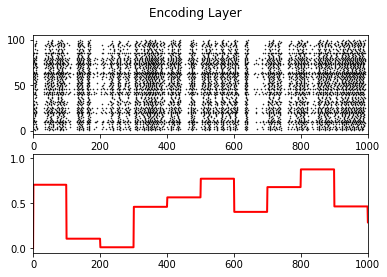

In [18]:
fig = pl.figure()
fig.suptitle('Encoding Layer')
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(enc_activity['times'], enc_activity['senders'], '.k', markersize=1)
ax12.plot(signal, 'r', linewidth=2)
ax11.set_xlim([0., T*duration])
pl.show()

Low-pass filter the spikes to obtain a continuous activity state $A(t)$

In [19]:
filter_tau = 20. # [ms]
enc_states = filter_spikes(enc_activity['times'], enc_activity['senders'], nEnc, 0., T*duration, dt, filter_tau)

Filtering SpikeTrains [                                                                                                  >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


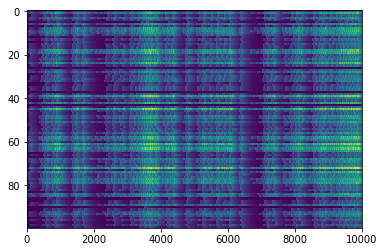

In [20]:
pl.imshow(enc_states, aspect='auto')
pl.show()

## Visualize main population activity
We are only going to focus on the excitatory population

In [21]:
e_activity = nest.GetStatus(spikes_e)[0]['events']
# i_activity = nest.GetStatus(spikes_i)[0]['events']

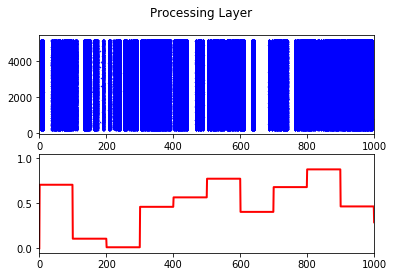

In [22]:
fig = pl.figure()
fig.suptitle('Processing Layer')
ax11 = fig.add_subplot(211)
ax12 = fig.add_subplot(212, sharex=ax11)
ax11.plot(e_activity['times'], e_activity['senders'], '.b', markersize=1)
ax12.plot(signal, 'r', linewidth=2)
ax11.set_xlim([0., T*duration])
pl.show()

In [23]:
e_states = filter_spikes(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau)

Filtering SpikeTrains [                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

# Decoding
If the input-driven dynamics contains enough information, we should be able to reconstruct some target signal.. For this purpose, we will use standard linear regression (see functions). If the state of the circuit (be it the encoding layer or the main processing layer is stored in a matrix $A$ and the target signal to reconstruct is $y$, we can estimate the optimal linear projection as:
\begin{equation}
D = \left( A^{T}A\right)^{-1} A^{T}Y
\end{equation}

In the simplest case, we want to reconstruct the original signal, i.e. $y(t)=x(t)$. 

In [24]:
def compute_capacity(a, y):
	"""
	Compute capacity to reconstruct y based on linearly combining a
	:param a: state matrix (NxT)
	:param y: target output (1xT)
	:return y_hat: estimated signal
    :return capacity: 
    :return error:
	"""
	D = np.dot(np.linalg.pinv(a.T), y.T)
	y_hat = np.dot(D, a)
	capacity = 1. - (np.mean((y - y_hat) ** 2) / np.var(y))
	error = np.mean((y - y_hat) ** 2)
	return y_hat, capacity, error

enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal)
circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal)

print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

Encoding Layer: 
	- Capacity=0.508303171227914, MSE=0.04062908489608003
Main Circuit: 
	- Capacity=0.8084631147278409, MSE=0.01582676136408525


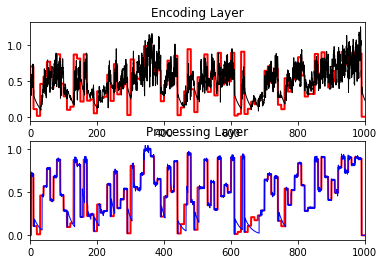

In [25]:
fig = pl.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(time_vector, signal, 'r', linewidth=2)
ax1.plot(time_vector, enc_estimate, 'k', linewidth=1)
ax1.set_xlim([0., T*duration])
ax1.set_title('Encoding Layer')
ax2.plot(time_vector, signal, 'r', linewidth=2)
ax2.plot(time_vector, circ_estimate, 'b', linewidth=1)
ax2.set_xlim([0., T*duration])
ax2.set_title('Processing Layer')
pl.show()

# Memory capacity
For practical purposes, it is simpler to downsample the continuous signals, take only one sample per input value and use that to compute a "discretized" memory curve (integer time lags). However, we will start with the full responses in this example. The circuit's capacity to reconstruct $y(t)$ by linearly combining the population responses is given by (see also `compute_capacity` function above):
\begin{equation}
\mathrm{C}[\mathrm{A}, \mathrm{y}]=\frac{\left(A^{T} A\right)^{-1} A y}{\|y\|^{2}}
\end{equation}

where the target function $y(t)$ can be any arbitrary function of the input, i.e. $y(t)=f(x(t))$. To compute the memory capacity, we set the target functions to be the original input shifted in time. The idea being that if the circuit has memory, the present state at any given time $t$ should contain information about the input that is driving it $x(t)$, but also about past history of the input (fading memory), i.e. $x(t-\tau_{\mathrm{lag}})$, for $\tau_{\mathrm{lag}} \in [0, \tau^{\mathrm{max}}_{\mathrm{lag}}]$.

In [26]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] - if != dt (index the time axis)
time_lags = np.arange(0., max_lag, step_lag)
indices = [np.where(idx==time_vector)[0][0] for idx in time_lags]

encoder_capacity = []
circuit_capacity = []

for idx, lag in zip(indices, time_lags):
    
    # shift the target signal
    if idx > 0:
        shifted_signal = signal[:-idx]
    else:
        shifted_signal = signal
    
    # shift the population states
    enc_st = enc_states[:, idx:]
    circ_st = e_states[:, idx:]
    
    # compute capacity
    enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
    circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
    print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))
    
    encoder_capacity.append(enc_capacity)
    circuit_capacity.append(circ_capacity)

Lag = 0.0 ms
Encoding Layer: 
	- Capacity=0.508303171227914, MSE=0.04062908489608003
Main Circuit: 
	- Capacity=0.8084631147278409, MSE=0.01582676136408525
Lag = 10.0 ms
Encoding Layer: 
	- Capacity=0.6091845461170416, MSE=0.03161607965369232
Main Circuit: 
	- Capacity=0.8651784231064472, MSE=0.01090675834784034
Lag = 20.0 ms
Encoding Layer: 
	- Capacity=0.3662548543839659, MSE=0.05085754167726706
Main Circuit: 
	- Capacity=0.8100371936230959, MSE=0.01524436346262339
Lag = 30.0 ms
Encoding Layer: 
	- Capacity=0.2585833354126653, MSE=0.05888989206684849
Main Circuit: 
	- Capacity=0.7934937630539096, MSE=0.01640255821826593
Lag = 40.0 ms
Encoding Layer: 
	- Capacity=0.16934992835316065, MSE=0.06578832620514637
Main Circuit: 
	- Capacity=0.773680468554624, MSE=0.01792473590209306
Lag = 50.0 ms
Encoding Layer: 
	- Capacity=0.15221136087205278, MSE=0.066407760906118
Main Circuit: 
	- Capacity=0.7590326843377698, MSE=0.018875105357800657
Lag = 60.0 ms
Encoding Layer: 
	- Capacity=0.097679383

Visualize the memory curves

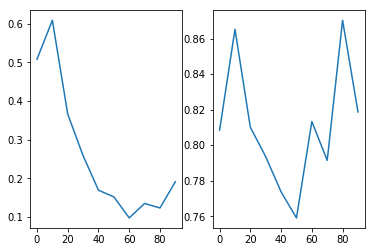

In [27]:
fig = pl.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(time_lags, encoder_capacity)
ax2.plot(time_lags, circuit_capacity)

pl.show()

NOTE: the reliability of these results id dependent on the length of the input signal and on the results one would obtain with a random process. Without these comparisons, the results are not entirely reliable.

To be able to address these issues, one would need to use a much longer simulation time (at least $10^5$. Naturally, this complicates things: filtering these long spike trains would take too long, the state matrices become very large and memory consuming and the capacity calculation would also take too long and require large memory!

In [29]:
print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))

Total capacity (encoder): 26.114708167018517 ms
Total capacity (processor): 81.03543497650458 ms
